In [104]:
import warnings
warnings.filterwarnings('ignore')

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shap
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [106]:
file_path = "/content/gymobesity.csv.xlsx"
df = pd.read_excel(file_path)

In [107]:
display(df.head())

,state,population,gyms,per 100k,obesity_rate
0,Massachusetts,6981974,7406,10.607,NaN
1,Colorado,5839926,5756,9.856,25.0
2,New Hampshire,1388992,1286,9.259,NaN
3,Wyoming,581381,525,9.030,NaN
4,California,39029342,34308,8.790,NaN


In [108]:
df['obesity_rate'].fillna(df['obesity_rate'].mean(), inplace=True)

In [109]:
df['Gyms per Capita'] = df['gyms'] / df['population']
df['Gym Accessibility'] = df['gyms'] / (df['population'] ** 0.5)

In [110]:
# Update this path to where you extracted the shapefile
shapefile_path = "/content/ne_10m_admin_1_states_provinces.shp"

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Filter for only US states
us_map = gdf[gdf['admin'] == 'United States of America']


In [111]:
df_map = us_map.merge(df, left_on='name', right_on='state', how='left')

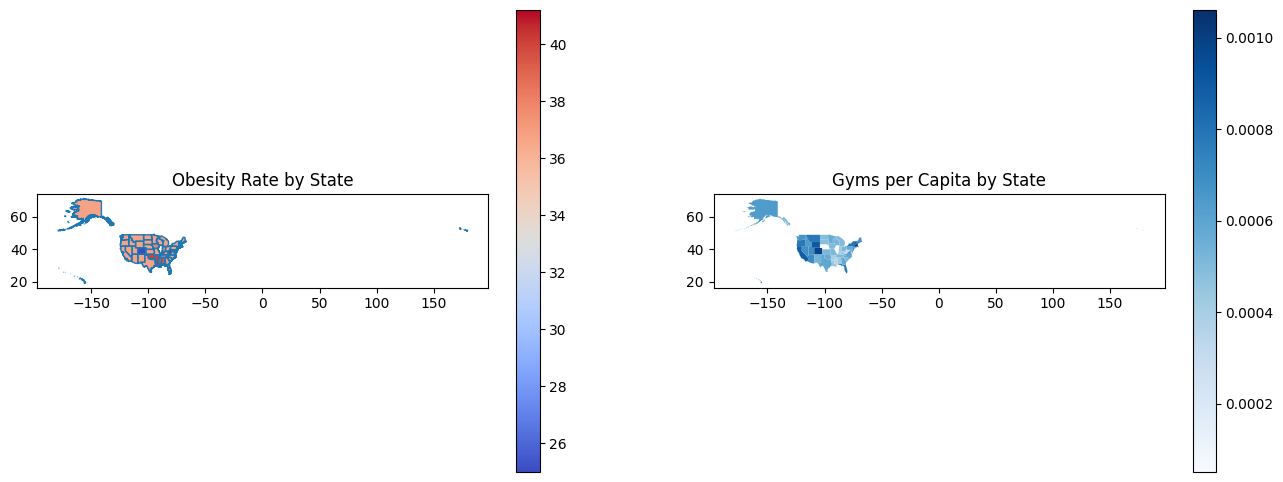

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
us_map.boundary.plot(ax=ax[0], linewidth=1)
df_map.plot(column='obesity_rate', cmap='coolwarm', legend=True, ax=ax[0])
ax[0].set_title("Obesity Rate by State")
df_map.plot(column='Gyms per Capita', cmap='Blues', legend=True, ax=ax[1])
ax[1].set_title("Gyms per Capita by State")
plt.show()

In [113]:
X = df[['population', 'gyms', 'per 100k', 'Gyms per Capita', 'Gym Accessibility']]
y = df['obesity_rate']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [116]:
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None]}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_

In [117]:
rf = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'], random_state=42)
rf.fit(X_train_scaled, y_train)

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train_scaled, y_train)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.1)

In [118]:
estimators = [('rf', rf), ('xgb', xgb), ('lasso', lasso)]
stacked_model = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor())
stacked_model.fit(X_train_scaled, y_train)

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=10,
                                                     random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            im...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('lasso', Lasso(alpha=0.1))],
                  final_estimator=RandomForestRegressor())

In [119]:
# ANN Model with Batch Normalization
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, verbose=0)

In [120]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"{model_name} Performance:")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R2 Score:", r2_score(y_test, y_pred))
    print("----------------------")

In [121]:
evaluate_model(rf, X_test_scaled, y_test, "Random Forest")
evaluate_model(xgb, X_test_scaled, y_test, "XGBoost")
evaluate_model(lasso, X_test_scaled, y_test, "Lasso Regression")
evaluate_model(stacked_model, X_test_scaled, y_test, "Stacked Model")
evaluate_model(model, X_test_scaled, y_test, "Neural Network")

Random Forest Performance:
MAE: 0.4868615384615701
MSE: 0.5294980426035663
R2 Score: 0.28767514195124866
----------------------
XGBoost Performance:
MAE: 0.33534211378831313
MSE: 0.3168032372622412
R2 Score: 0.5738099051271338
----------------------
Lasso Regression Performance:
MAE: 0.6646231466329879
MSE: 0.5111144032762838
R2 Score: 0.3124063443742767
----------------------
Stacked Model Performance:
MAE: 0.5166000000000217
MSE: 0.5905604284023773
R2 Score: 0.20552893592868593
----------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Neural Network Performance:
MAE: 5.815632811326241
MSE: 37.0805932918074
R2 Score: -48.88390178568772
----------------------


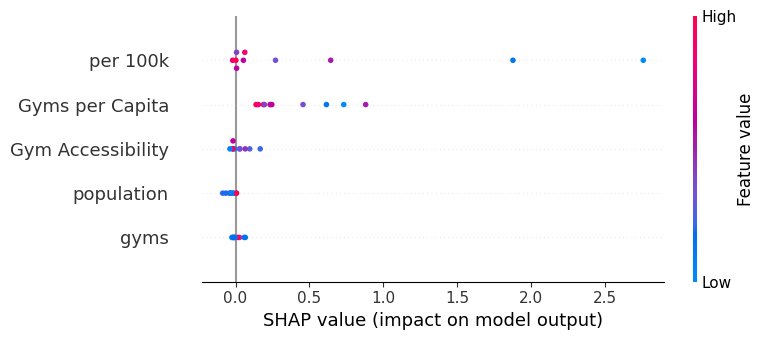

In [122]:
explainer = shap.Explainer(rf)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)